# PHYS 309 Final Data Analysis

November 25, 2017

In [1]:
# Some math and stats functions I'll need
%pylab inline
from scipy.integrate import simps
from scipy.optimize import curve_fit
from scipy.stats import sem, chisquare
from statsmodels.stats.weightstats import DescrStatsW

# Make my plots prettier
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_context('paper', font_scale=1.2)
%config InlineBackend.figure_format = 'retina'

# For loading and sorting my data
from os import listdir
from natsort import natsorted
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define some useful functions I'll use many times
def load_data(dir_regex_str, pol_t_path):
    """Load the data from the directory selected by dir_regex_str and the pol_t_path
    INPUTS:
        - (String) dir_regex_str: Regex expression to find the directory with all the data for one concentration of salt.
        - (String)    pol_t_path: Relative path to a file containing the polarization times used.
    OUTPUTS:
        - (3D numpy array) data: the time domain signal for each run and polarization time.
        - (numpy array)   pol_t: array of polarization times used in ms.
    """
    
    data_dirs = natsorted(glob.glob(dir_regex_str))
    data_sets = [natsorted(glob.glob(ds + '/data*')) for ds in data_dirs]
    data = []
    for data_set in data_sets:
        data.append([np.loadtxt(f) for f in data_set])

    pol_t = loadtxt(pol_t_path) / 1000  # convert from ms to s
    return data, pol_t

In [3]:
def model(t, T1, M0, d):
    """Exponential model for fitting signal strength vs polarization time."""
    return M0 * (1-exp(-t/T1)) + d

In [4]:
def get_T1(data, pol_t, peak_lims, peak_widths, p0=[2.4, 100000, 500], 
           plt_best_fit=True, plt_worst_fit=True, plt_best_residuals=True, plt_worst_residuals=True):
    """Return the estimated T1 time.
     - data (array): time domain signal for each polarization time and each trial.
     - pol_t (array): array of polarization times
     - peak_lims: estimated peak limits
     - peak_widths: peak widths around maximum to try
    """
    popts = zeros((len(peak_widths), 3))
    chi2s = zeros(len(peak_widths))
    pvalues = zeros(len(peak_widths))
    peak_avgs = zeros((len(peak_widths), len(pol_t)))  # (n peak widths) x (n polarization times)
    err_peak_avgs = zeros((len(peak_widths), len(pol_t)))  # (n peak widths) x (n polarization times)

    T1s = zeros(len(peak_widths))
    uT1s = zeros(len(peak_widths))
    
    for pw in range(len(peak_widths)):  # for each peak width
        peak_areas = zeros((shape(data)[0], len(pol_t))) # (n trials) x (n polarization times)
        for tr in range(shape(data)[0]): # for each trial
            for pt in range(len(pol_t)):  # for each polarization time
                # Calculate the discrete fourier transform and frequency
                F = fft.fft(data[tr][pt])
                freq = fft.fftfreq(len(F), .0001)  # each step is 0.0001ms
                peak = logical_and(freq > peak_lims[0], freq < peak_lims[1])  # logical index for locating the peak
                peak_max = max(abs(F[peak]))
                peak_max_freq = freq[logical_and(abs(F) == peak_max, peak)]

                # redefine the peak area around the signal peak max
                peak = logical_and(freq > peak_max_freq-peak_widths[pw]/2, freq < peak_max_freq+peak_widths[pw]/2)   
                peak_areas[tr][pt] = simps(abs(F[peak]), freq[peak])  # calculate the area under the peak using simpson's rule

        avg_peak_areas = mean(peak_areas, axis=0)
        err_peak_areas = sem(peak_areas, axis=0)
        
        popt, pcov = curve_fit(model, pol_t, avg_peak_areas, sigma=err_peak_areas, p0=p0)

        model_pnts = model(pol_t, *popt)
        chi2, p = chisquare(avg_peak_areas, model_pnts, ddof=3)

        popts[pw] = popt
        chi2s[pw] = chi2
        pvalues[pw] = p
        peak_avgs[pw] = avg_peak_areas
        err_peak_avgs[pw] = err_peak_areas

        T1s[pw] = popt[0]
        uT1s[pw] = sqrt(diag(pcov))[0]
        
    weighted_stats = DescrStatsW(unique(T1s), weights=1/unique(uT1s)**2, ddof=0)

    T1 = weighted_stats.mean
    uT1 = sqrt(mean(unique(uT1s))**2 + weighted_stats.std**2)
    #T1 = average(T1s, weights=1/uT1s)
    #uT1 = sqrt(mean(uT1s)**2 + sem(T1s)**2)

    best_ind = where(chi2s==min(chi2s))
    best_avgs = peak_avgs[best_ind][0]
    err_best_avgs = err_peak_avgs[best_ind][0]
    best_popt = popts[best_ind][0]
    
    worst_ind = where(chi2s==max(chi2s))
    worst_avgs = peak_avgs[worst_ind][0]
    err_worst_avgs = err_peak_avgs[worst_ind][0]
    worst_popt = popts[worst_ind][0]

    if plt_best_fit:
        plot_fit(pol_t, best_avgs, err_best_avgs, best_popt)
    if plt_best_residuals:
        plot_residuals(pol_t, best_avgs, err_best_avgs, best_popt)
    if plt_worst_fit:
        plot_fit(pol_t, worst_avgs, err_worst_avgs, worst_popt)
    if plt_worst_residuals:
        plot_residuals(pol_t, worst_avgs, err_worst_avgs, worst_popt)
        
    return T1, uT1, popts, chi2s, pvalues, peak_avgs, err_peak_avgs, T1s, uT1s

def plot_ffts(pol_t, data, xlims, ylims):
    """Plot the Fourier transforms of the data with a separate figure for each trial."""
    cmap = plt.get_cmap('jet')  # colors for the plots 
    for m in range(shape(data)[0]): # for each trial
        figure()
        for n in range(len(pol_t)):  # for each polarization time
            F = fft.fft(data[m][n])
            freq = fft.fftfreq(len(F), .0001)  # each step is 0.0001s
            
            c = cmap(float(n)/len(pol_t))
            plot(freq, abs(F), color=c)
            
        xlim(xlims)  # Hz
        ylim(ylims)
        xlabel('Frequency (Hz)')
        ylabel('Spectrum')
    
def plot_peak_lims(pol_t, data, peak_lims, peak_widths, ylims):
    """Plot the FFT with the peak limits to use"""
    for m in range(shape(data)[0]):
        figure()
        F = fft.fft(data[m][-1])
        freq = fft.fftfreq(len(F), .0001)  # each step is 0.0001ms
        plot(freq, abs(F))

        peak = logical_and(freq > peak_lims[0], freq < peak_lims[1])  # logical index for locating the peak
        peak_max = max(abs(F[peak]))
        peak_max_freq = freq[logical_and(abs(F) == peak_max, peak)]
        
        for peak_width in peak_widths:
            # redefine the peak area around the signal peak max
            peak = logical_and(freq > peak_max_freq-peak_width/2, freq < peak_max_freq+peak_width/2)   
            axvline(freq[peak][0], linestyle='--')
            axvline(freq[peak][-1], linestyle='--')
            
        xlim([peak_lims[0]-.01, peak_lims[1]+.01])  # kHz
        ylim(ylims)
        xlabel('Frequency (Hz)')
        ylabel('Spectrum')
    
def plot_fit(pol_t, avg_peak_areas, err_peak_areas, popt):
    """Plot the data with the best model fit."""
    figure()
    x = linspace(0,10,100)
    scatter(pol_t, avg_peak_areas, s=15)
    errorbar(pol_t, avg_peak_areas, err_peak_areas, linestyle='None')
    plot(x, model(x, *popt))
    xlabel('Polarization time (s)')
    ylabel('Signal Strength (Area under the peak)')

def plot_residuals(pol_t, avg_peak_areas, err_peak_areas, popt):
    figure()
    residuals = avg_peak_areas - model(pol_t, *popt)
    scatter(pol_t, residuals)
    errorbar(pol_t, residuals, err_peak_areas, linestyle='None')
    hlines(0, 0, 10, colors='r')
    xlabel('Polarization Time (s)')
    ylabel('Residuals')
    

## Plain tap water

In [5]:
data0, pol_t0 = load_data('./nov1/*', './nov1/set1/array.txt')

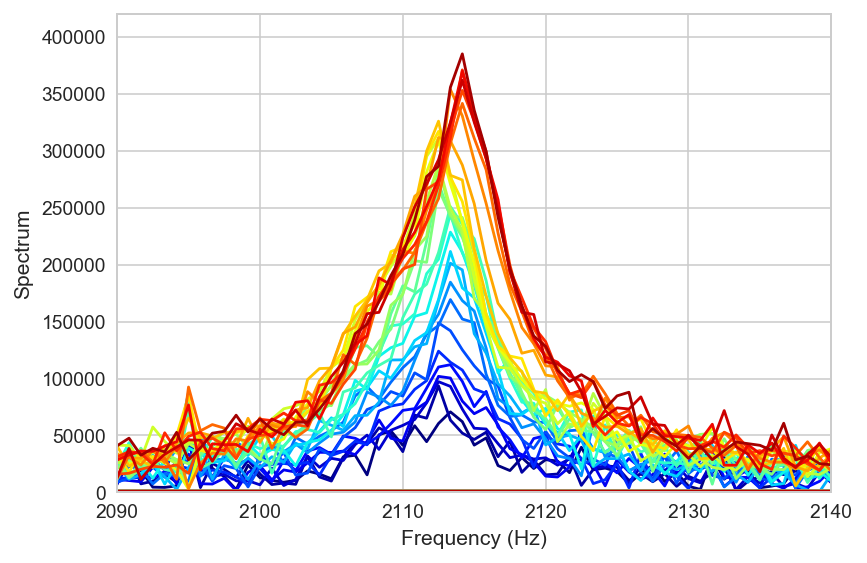

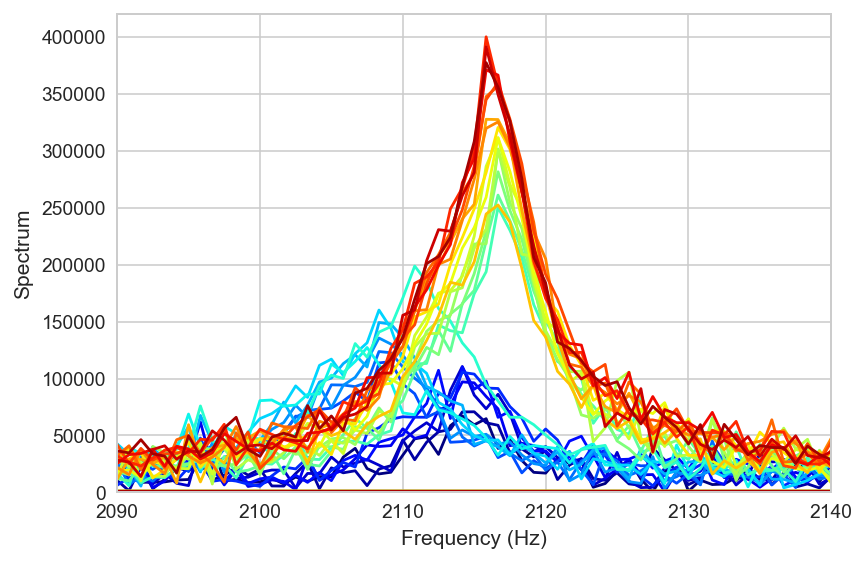

In [6]:
xlims0 = [2090, 2140]
ylims0 = [0, 420000]
plot_ffts(pol_t0, data0, xlims0, ylims0)

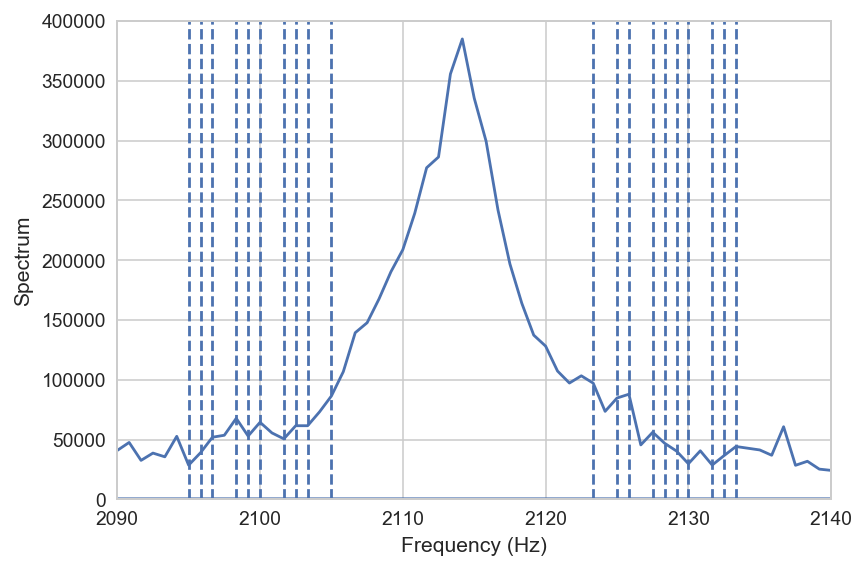

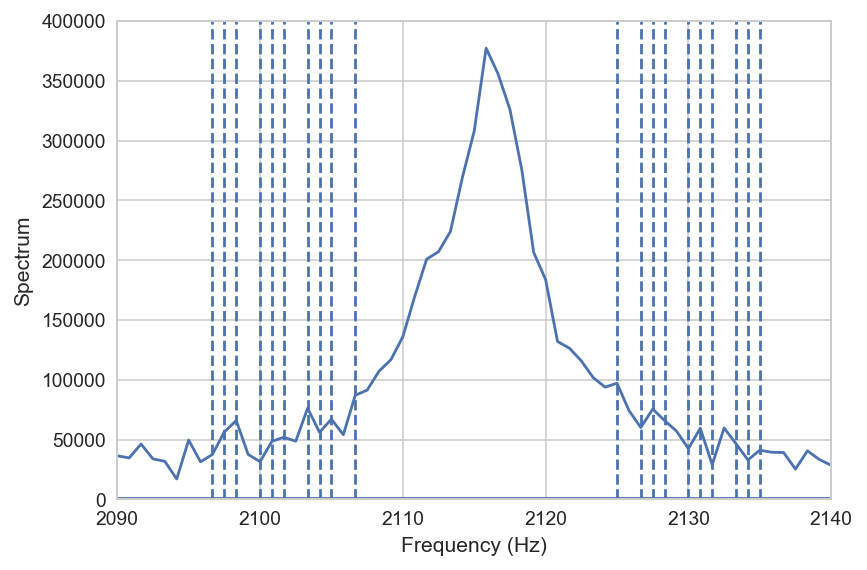

In [7]:
peak_lims0 = [2090, 2140]
peak_widths0 = linspace(20, 40, 10)
ylims = [0, 400000]
plot_peak_lims(pol_t0, data0, peak_lims0, peak_widths0, ylims)

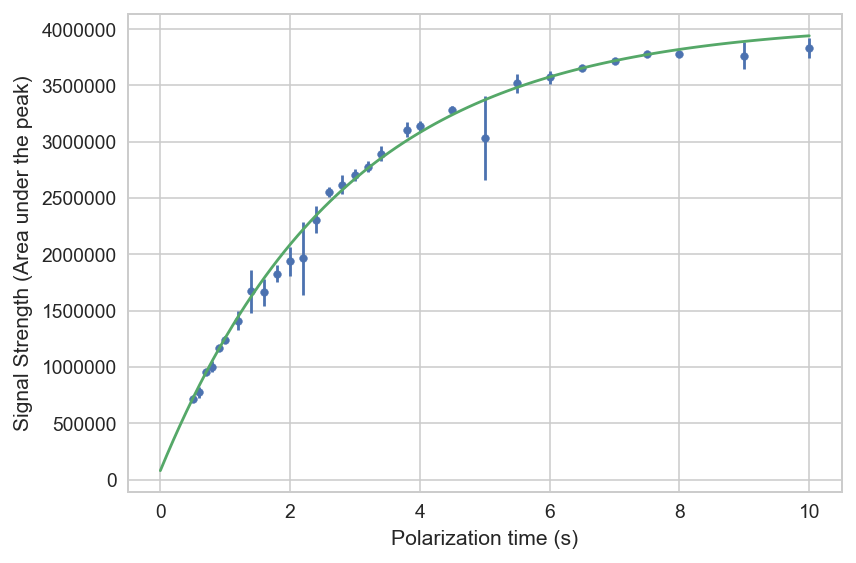

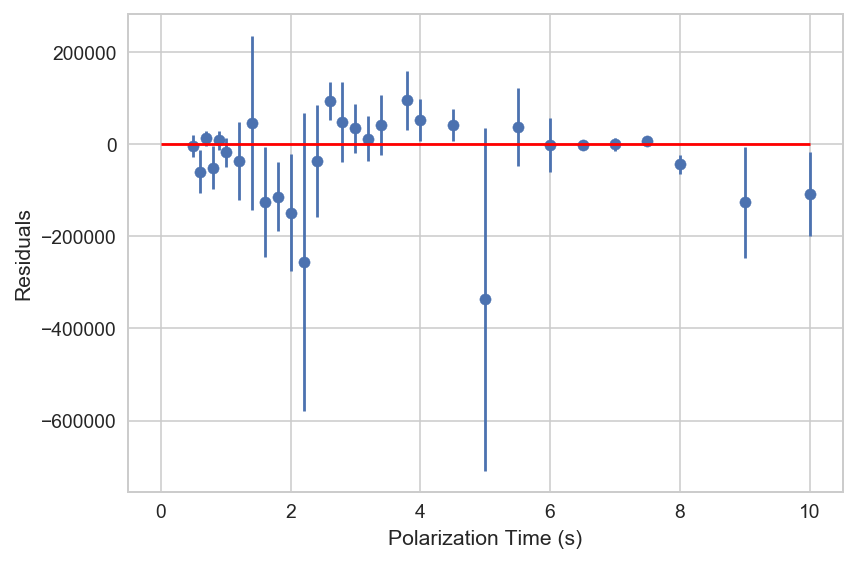

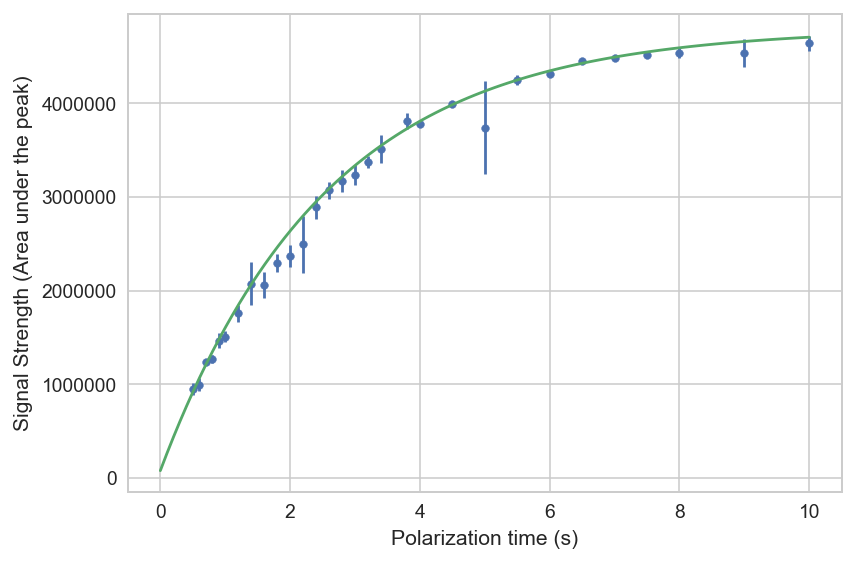

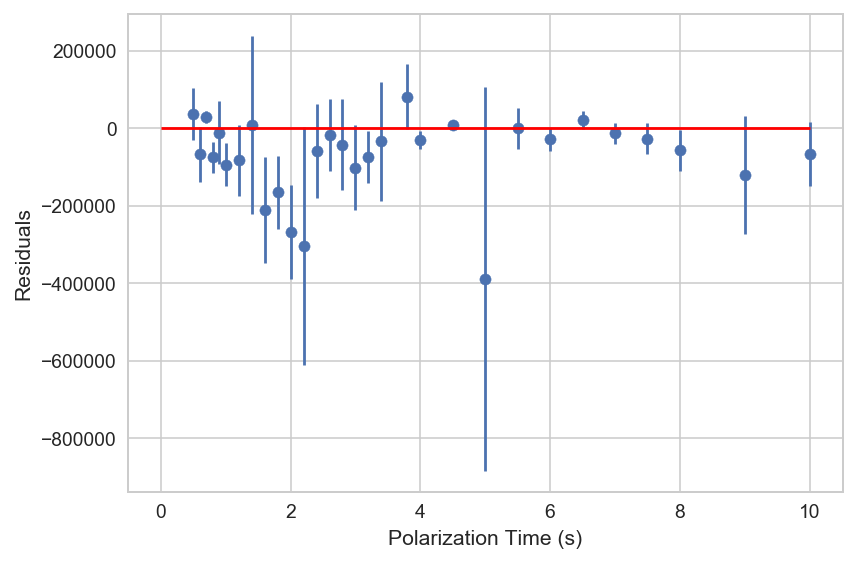

In [8]:
T1_0, uT1_0, popts_0, chi2s_0, pvalues_0, peak_avgs_0, err_peak_avgs_0, T1s_0, uT1s_0 = \
    get_T1(data0, pol_t0, peak_lims0, peak_widths0, p0=[2.6, 400000, 5000])

In [9]:
T1_0, uT1_0

(2.6096227520822302, 0.12107626220634062)

## 10.22g salt water

In [10]:
data10, pol_t10 = load_data('./nov15/10*', './nov15/10_22gsaltwaterset1/array.txt')

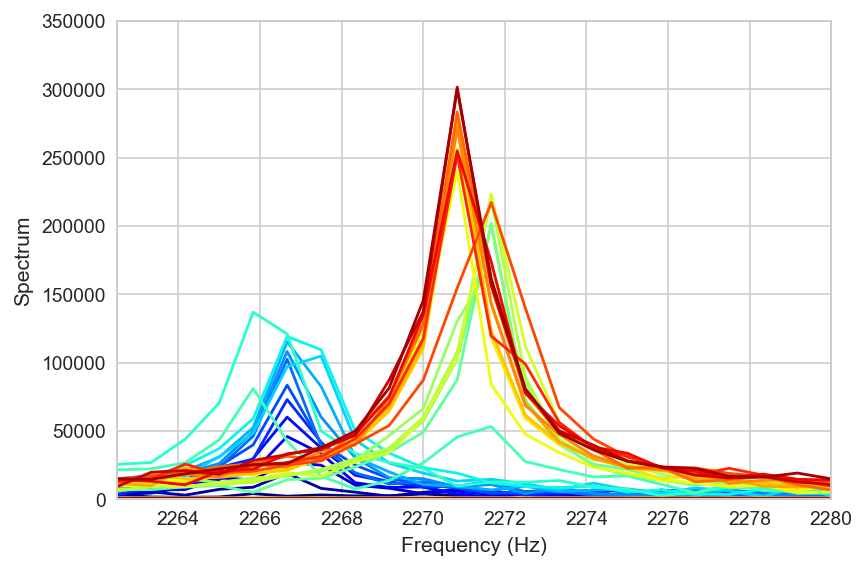

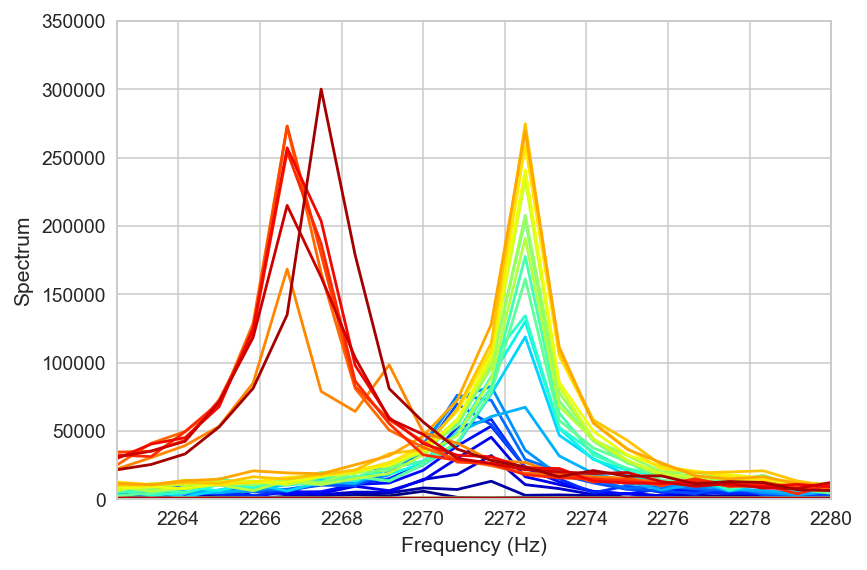

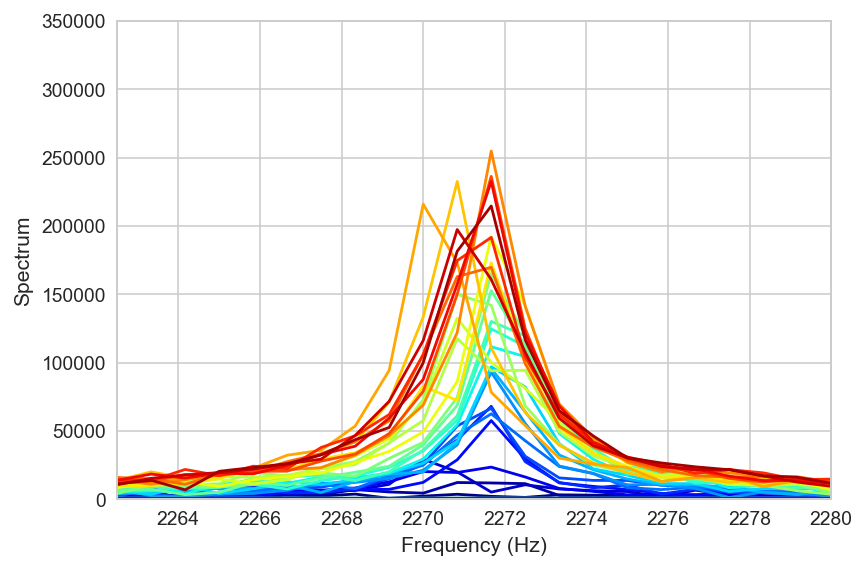

In [11]:
xlims10 = [2262.5, 2280]
ylims10 = [0, 350000]
plot_ffts(pol_t10, data10, xlims10, ylims10)

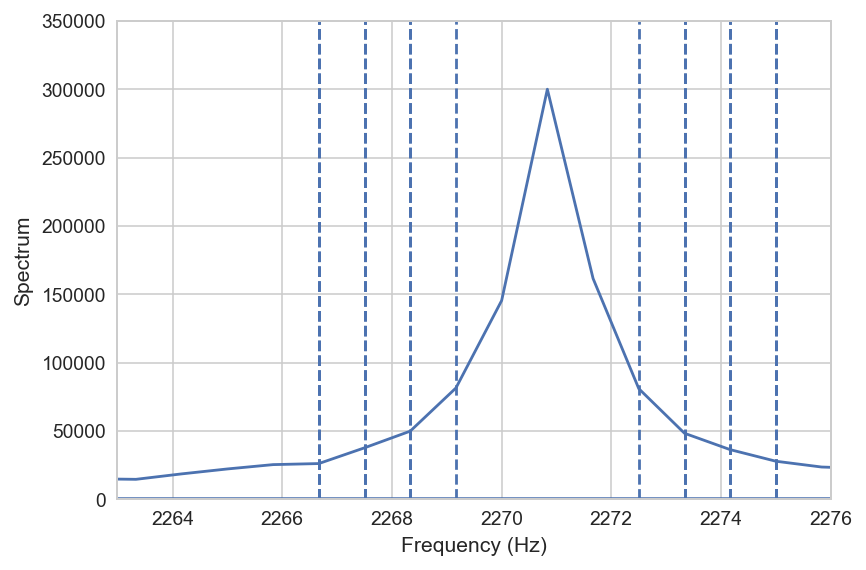

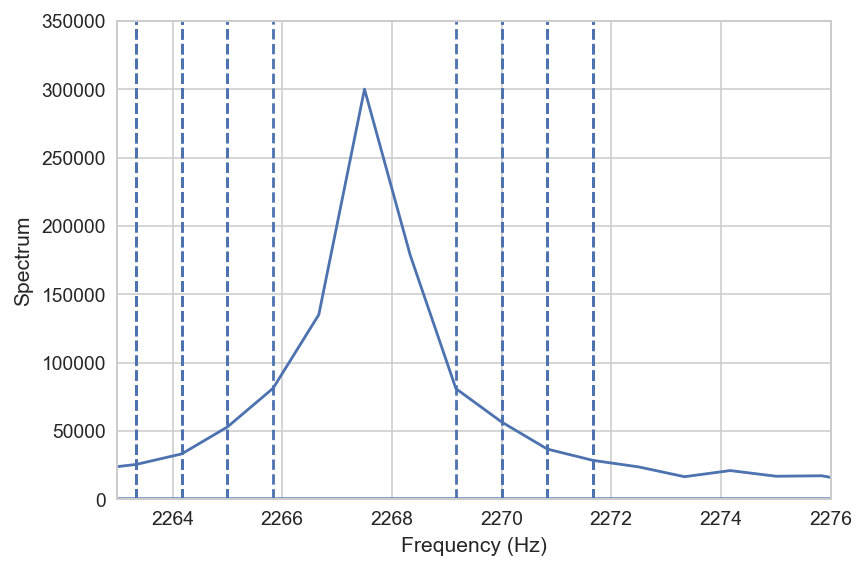

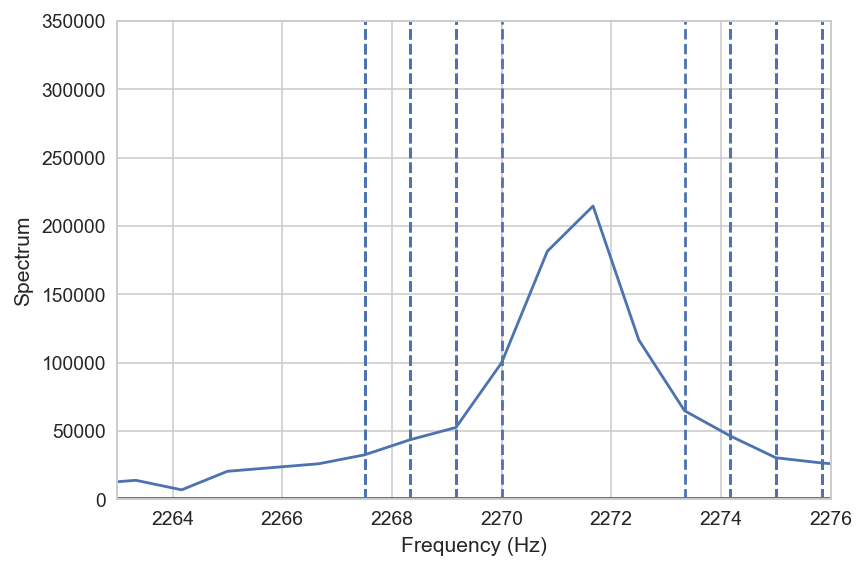

In [12]:
peak_lims10 = [2263, 2276]
peak_widths10 = linspace(5, 10, 10)
ylims10 = [0, 350000]
plot_peak_lims(pol_t10, data10, peak_lims10, peak_widths10, ylims10)

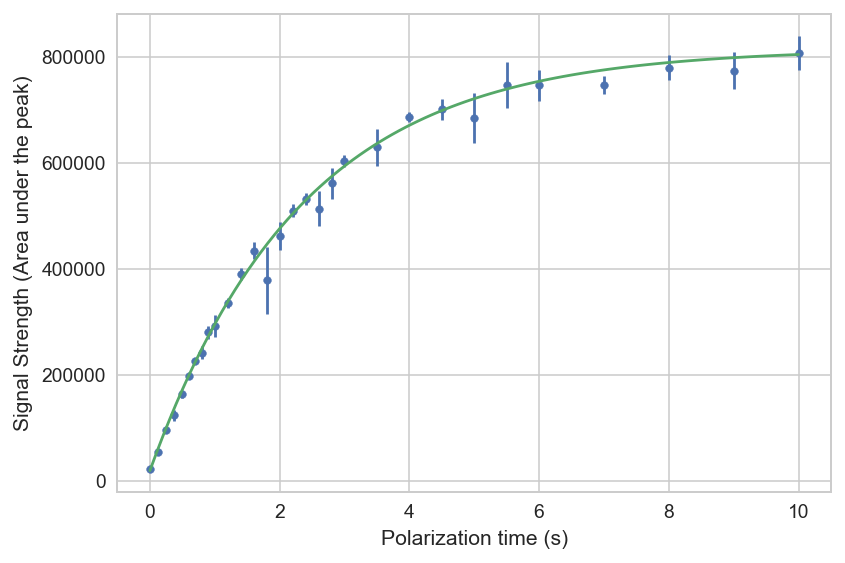

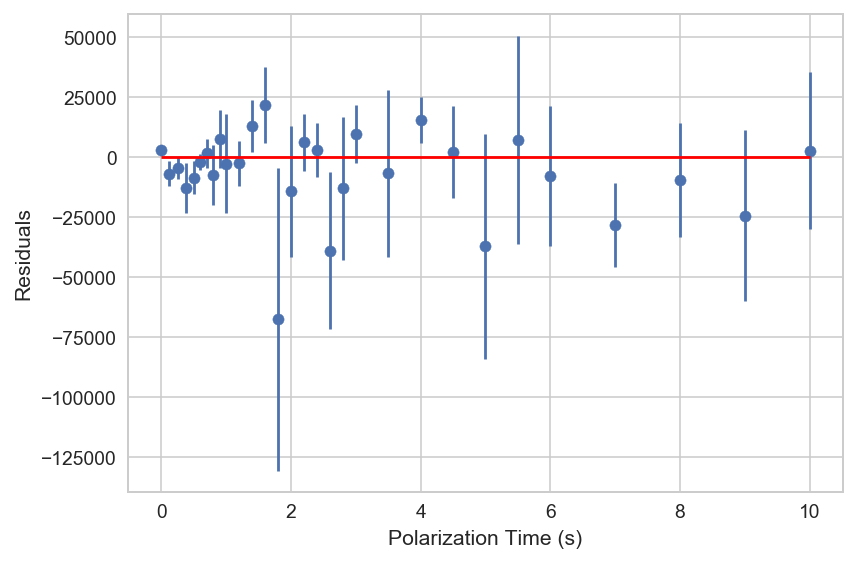

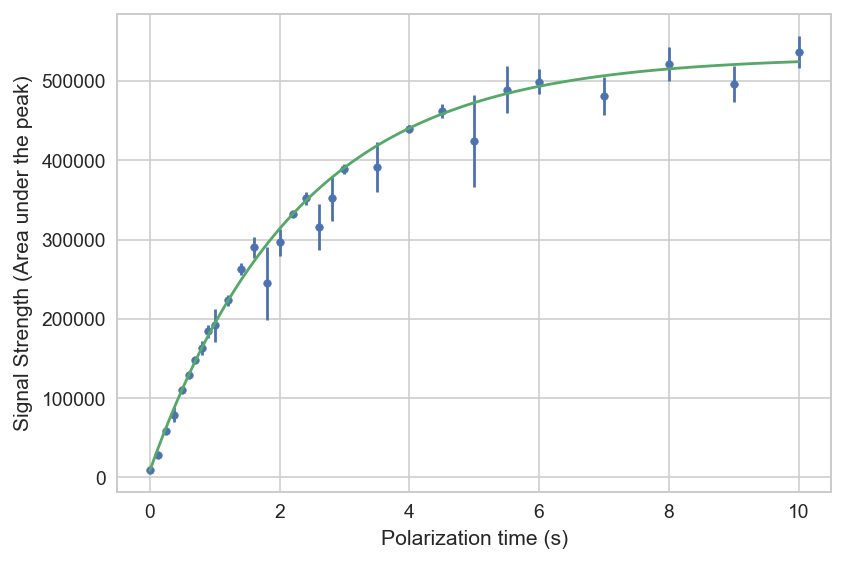

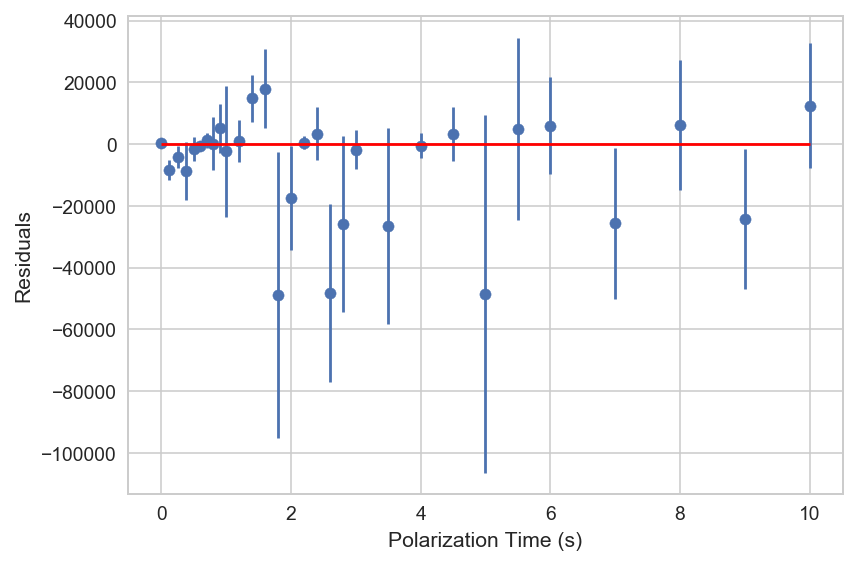

In [13]:
T1_10, uT1_10, popts_10, chi2s_10, pvalues_10, peak_avgs_10, err_peak_avgs_10, T1s_10, uT1s_10 = \
    get_T1(data10, pol_t10, peak_lims10, peak_widths10, p0=[2.3, 800000, 30])

In [14]:
T1_10, uT1_10

(2.3136583809799141, 0.065266917262095825)

## 30.88g salt water

In [15]:
data30, pol_t30 = load_data('./nov15/30*', './nov15/30_88gsaltwaterset1/array.txt')

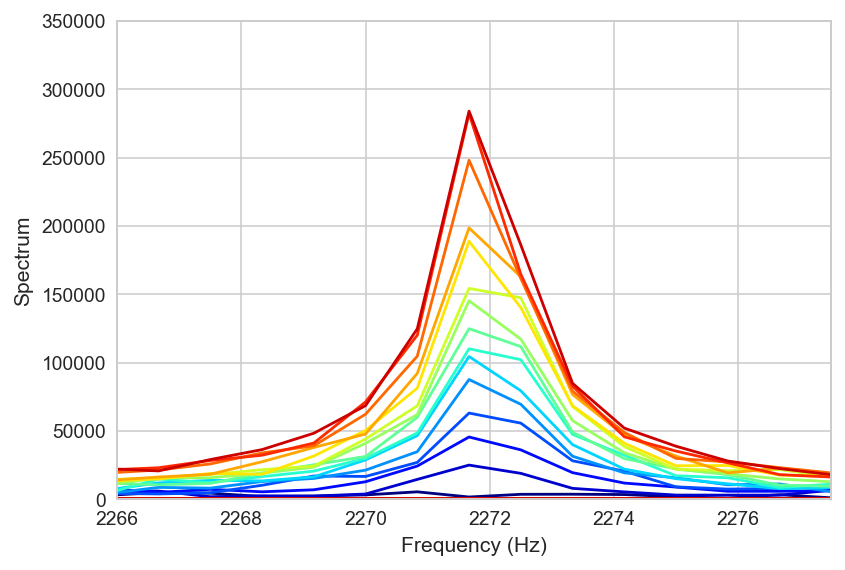

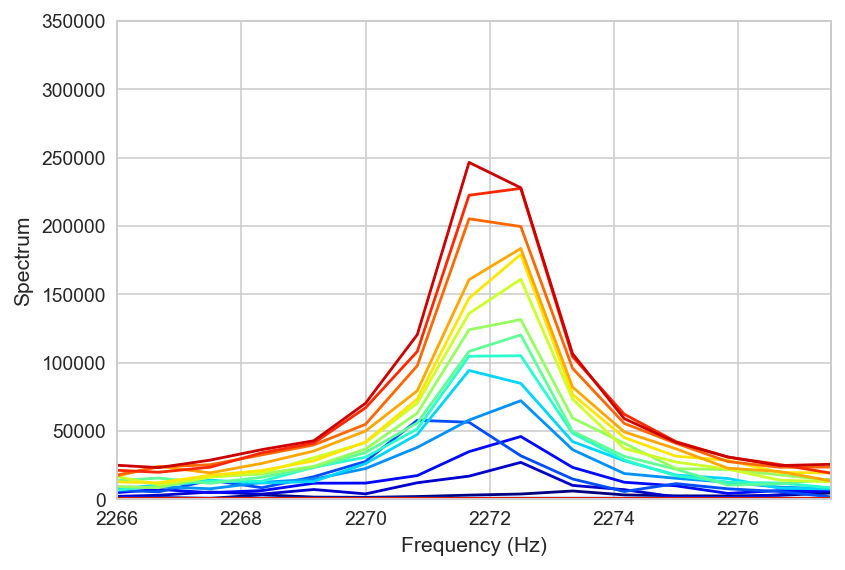

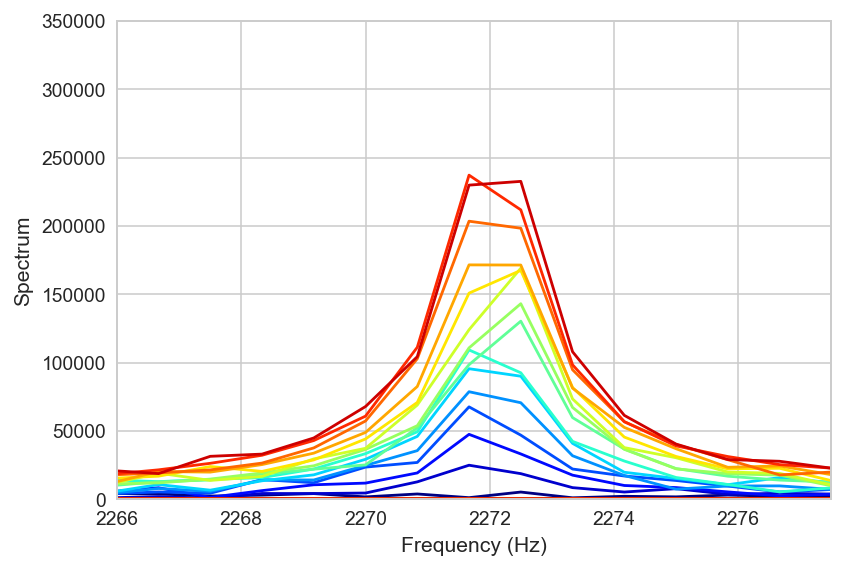

In [16]:
xlims30 = [2266, 2277.5]
ylims30 = [0, 350000]
plot_ffts(pol_t30, data30, xlims30, ylims30)

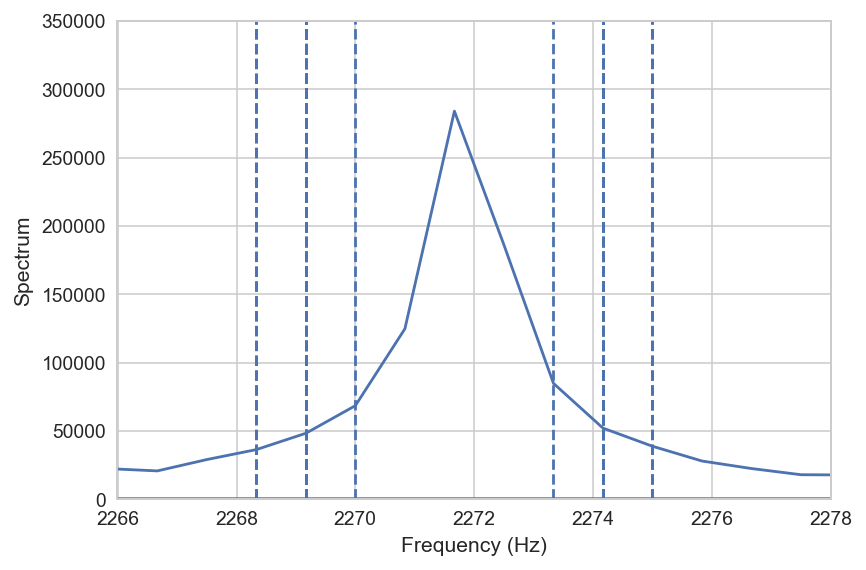

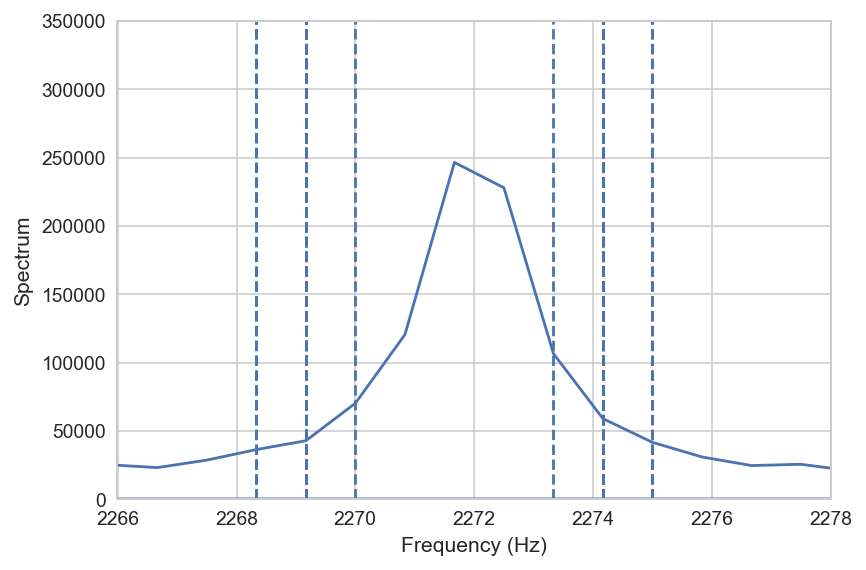

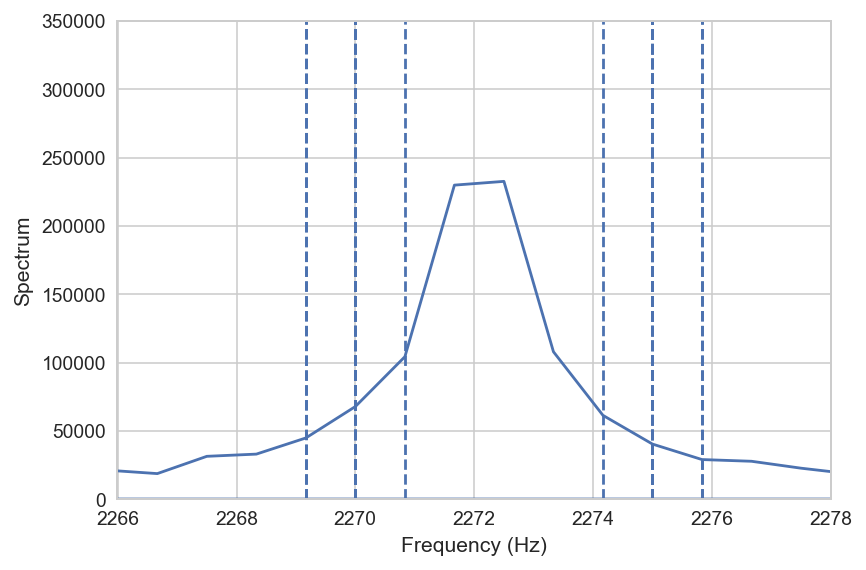

In [17]:
peak_lims30 = [2266, 2278]
peak_widths30 = linspace(5, 7, 10)
ylims30 = [0, 350000]
plot_peak_lims(pol_t30, data30, peak_lims30, peak_widths30, ylims30)

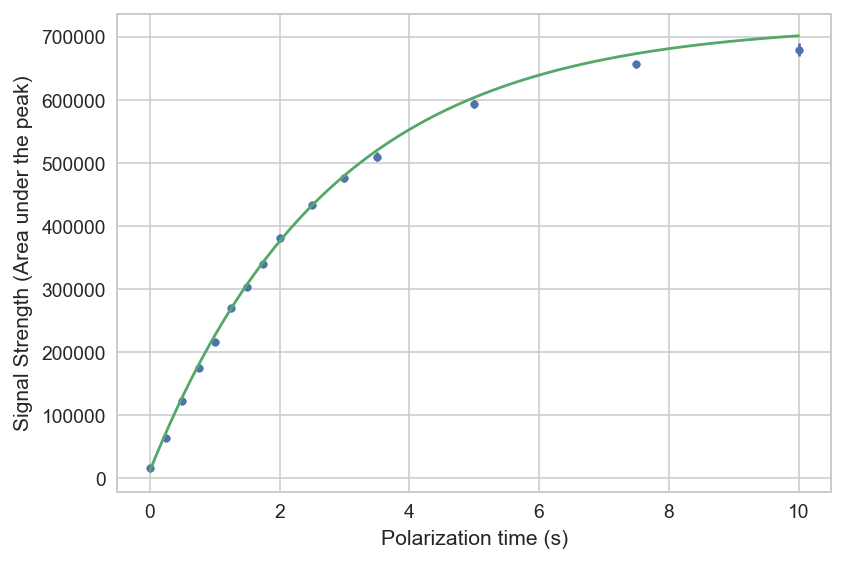

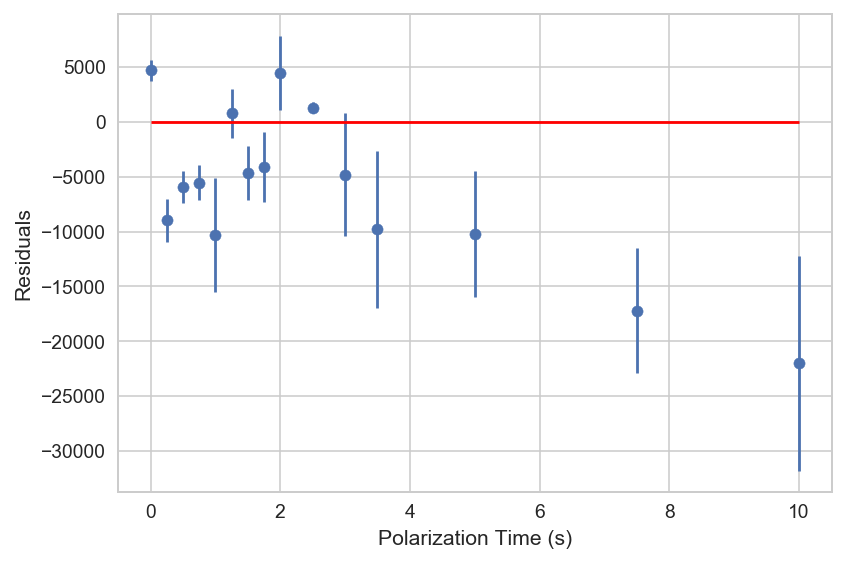

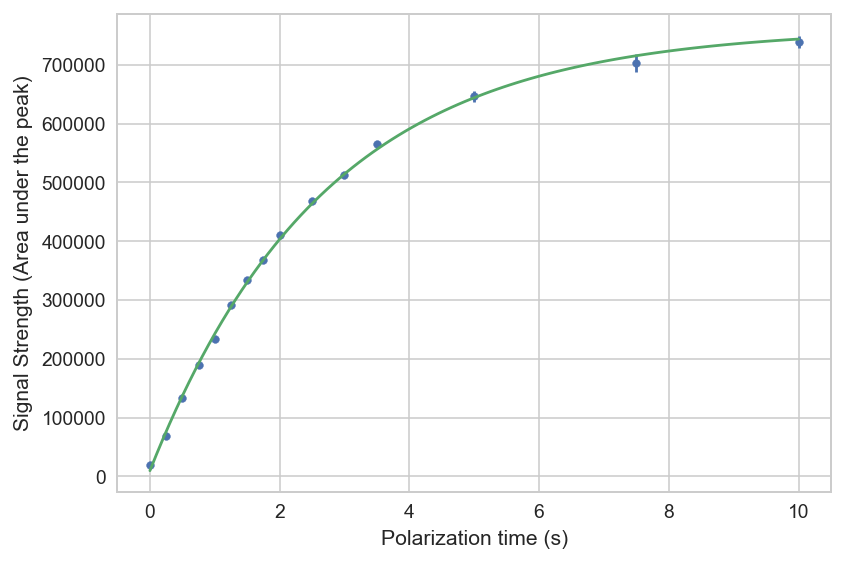

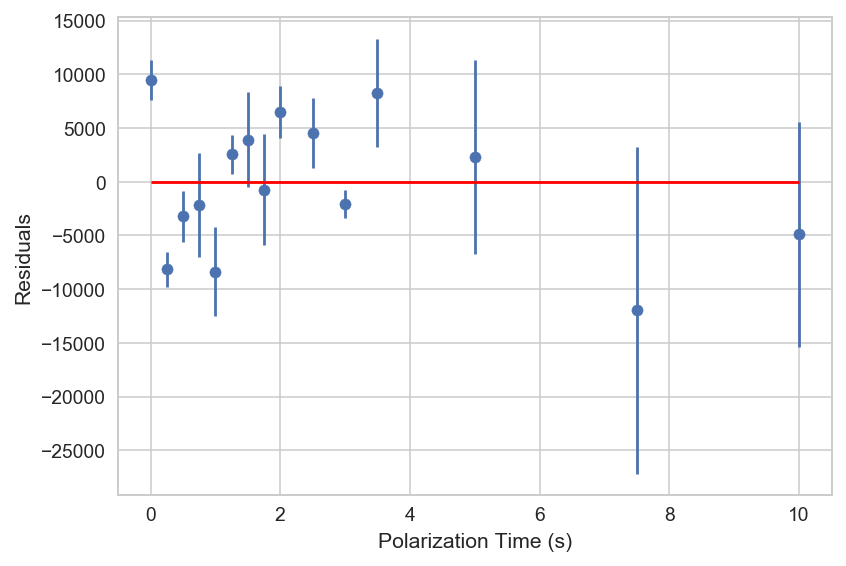

In [18]:
T1_30, uT1_30, popts_30, chi2s_30, pvalues_30, peak_avgs_30, err_peak_avgs_30, T1s_30, uT1s_30 = \
    get_T1(data30, pol_t30, peak_lims30, peak_widths30, p0=[2.7, 750000, 3000])

In [19]:
T1_30, uT1_30

(2.6996692485697529, 0.11597859611729749)

## 48.55g of salt

In [20]:
data48, pol_t48 = load_data('./nov15/48*', './nov15/48gsaltwaterset1/array.txt')

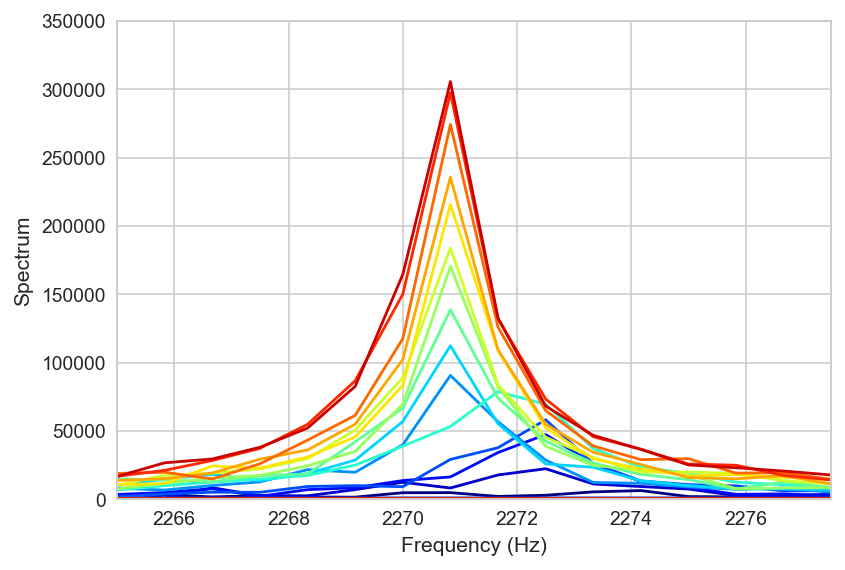

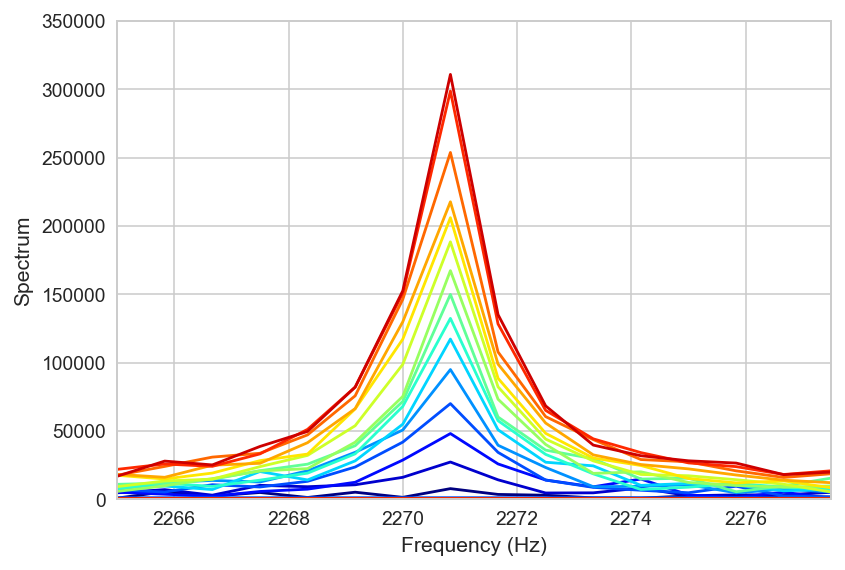

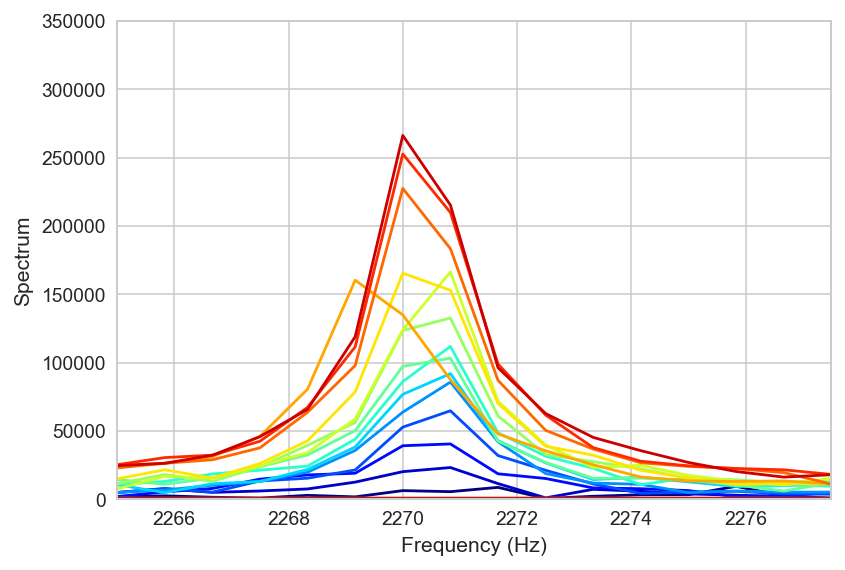

In [21]:
xlims48 = [2265, 2277.5]
ylims48 = [0, 350000]
plot_ffts(pol_t48, data48, xlims48, ylims48)

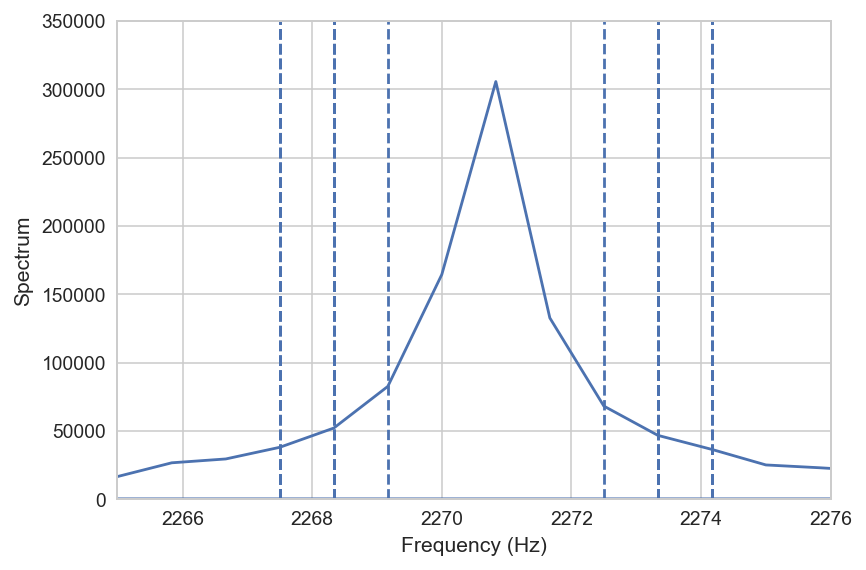

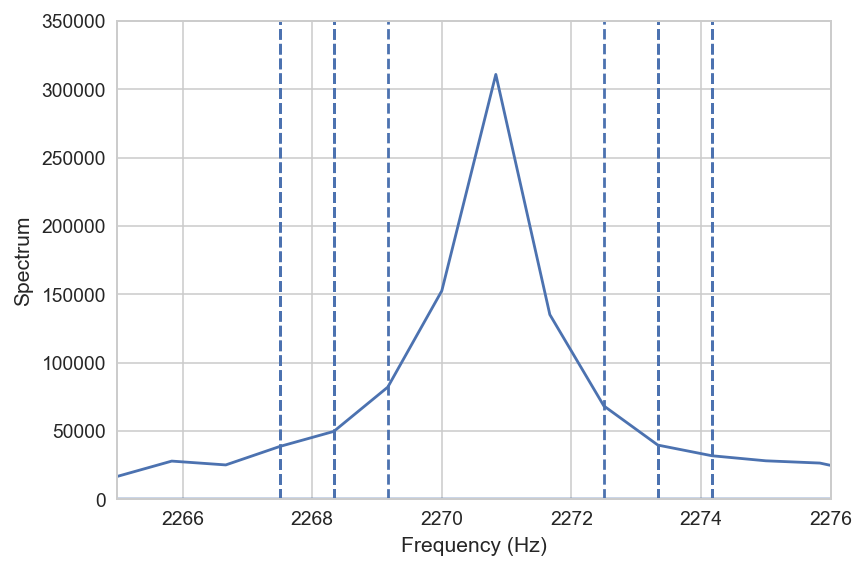

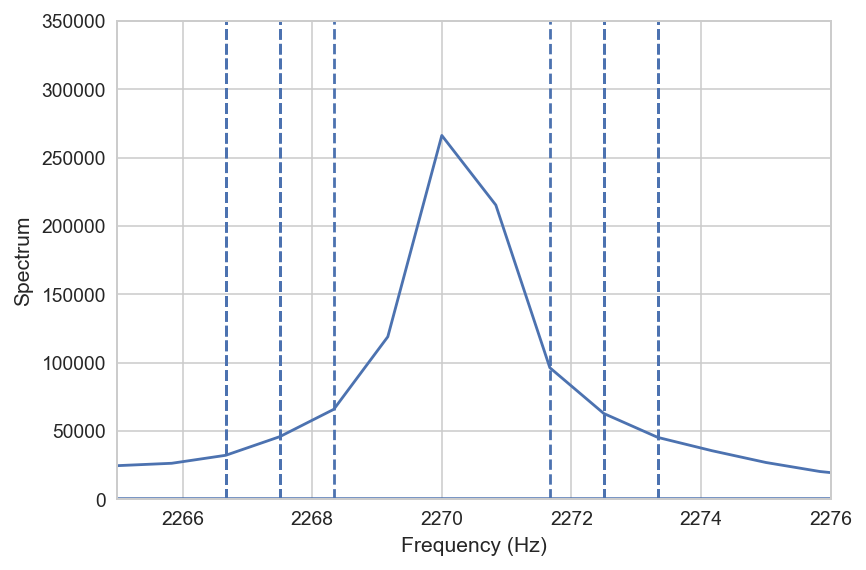

In [22]:
peak_lims48 = [2265, 2276]
peak_widths48 = linspace(5, 8, 10)
ylims30 = [0, 350000]
plot_peak_lims(pol_t48, data48, peak_lims48, peak_widths48, ylims48)

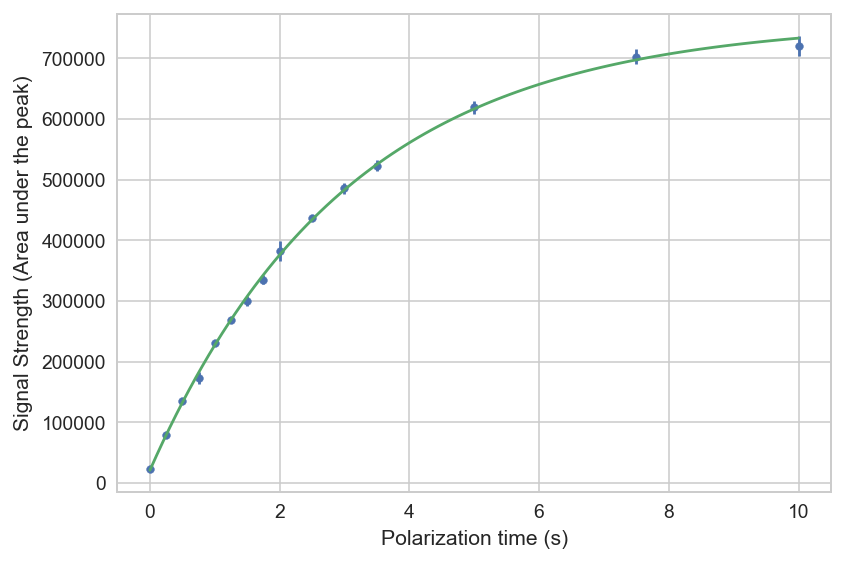

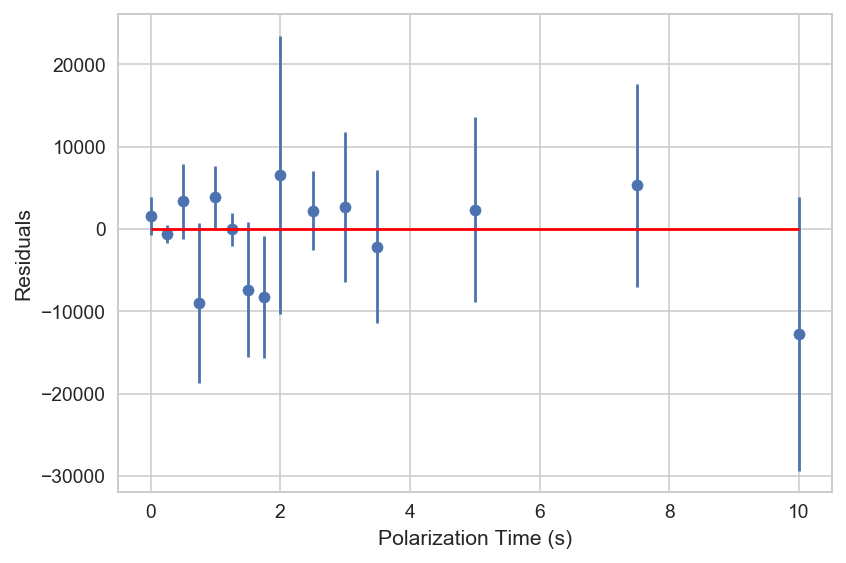

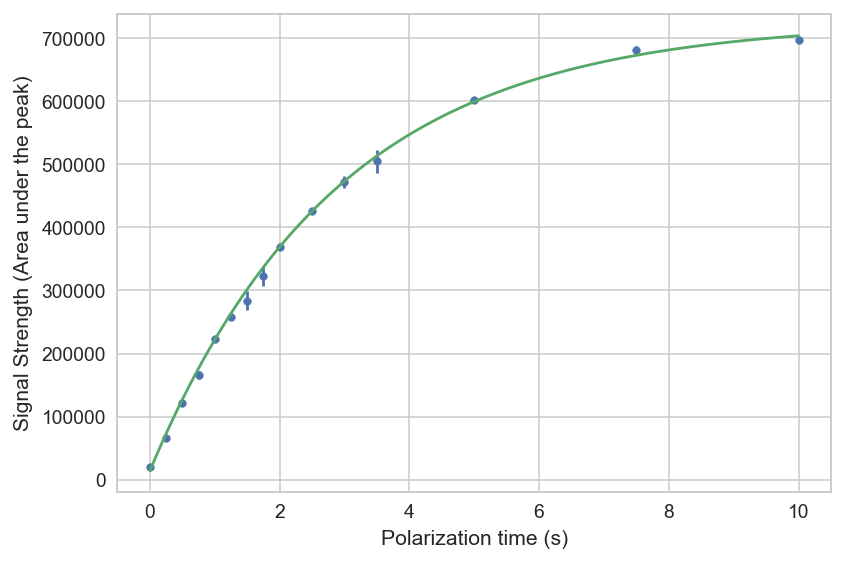

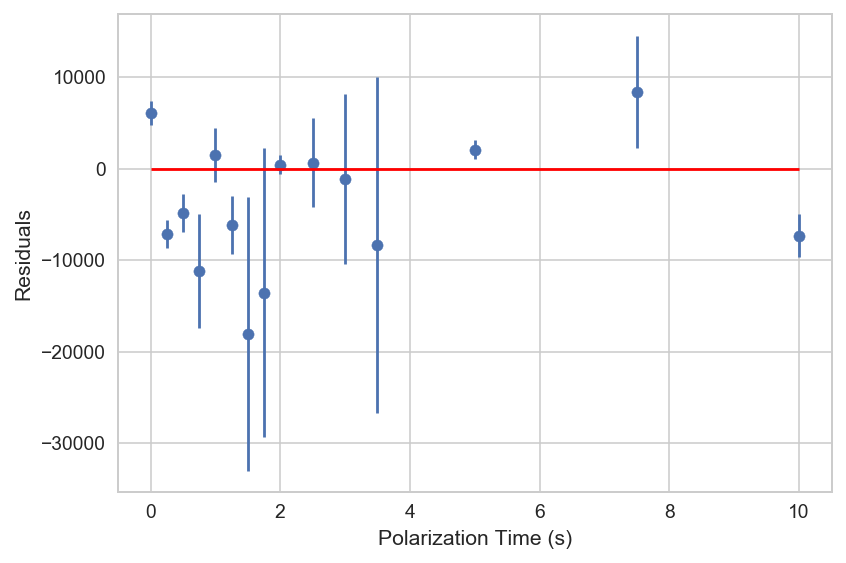

In [23]:
T1_48, uT1_48, popts_48, chi2s_48, pvalues_48, peak_avgs_48, err_peak_avgs_48, T1s_48, uT1s_48 = \
    get_T1(data48, pol_t48, peak_lims48, peak_widths48, p0=[3, 750000, 2000])

In [24]:
T1_48, uT1_48

(3.0087455971808112, 0.10305882127558398)

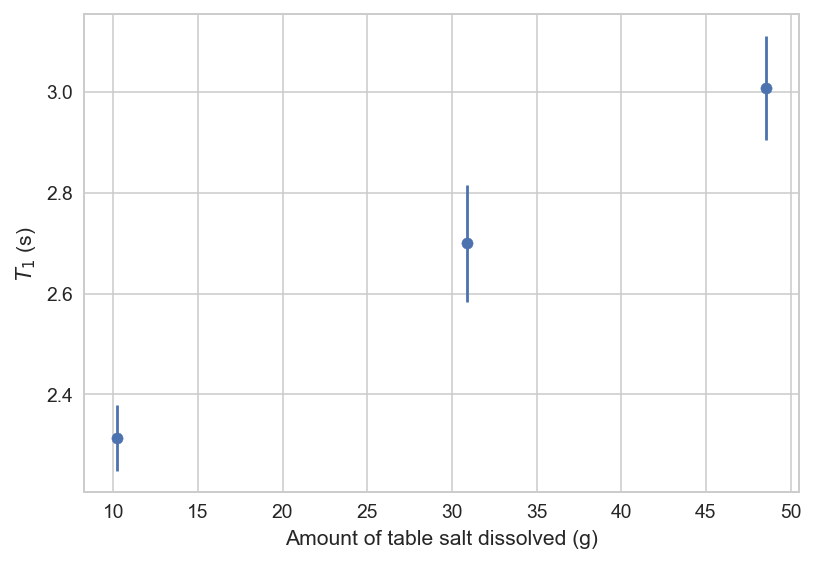

In [25]:
scatter([10.22, 30.88, 48.55], [T1_10,T1_30,T1_48])
errorbar([10.22, 30.88, 48.55], [T1_10,T1_30,T1_48], yerr=[uT1_10,uT1_30,uT1_48], linestyle='none')
ylabel('$T_1$ (s)')
xlabel('Amount of table salt dissolved (g)')

In [26]:
def linear_model(x, m, b):
    return m*x + b

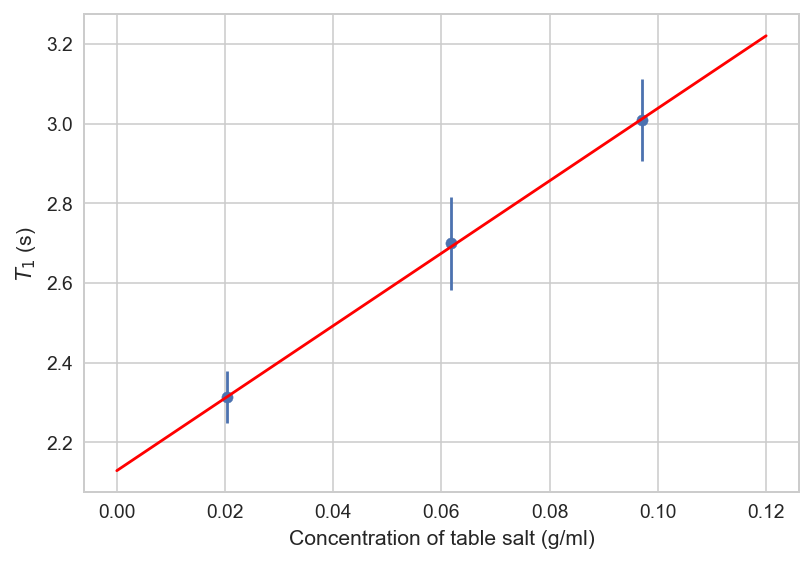

In [27]:
salt_mass = array([10.22, 30.88, 48.55])  # in grams
conc = salt_mass / 500  # concentration of salt in g/ml
T1_salt = [T1_10,T1_30,T1_48]
uT1_salt = [uT1_10,uT1_30,uT1_48]
popt, pcov = curve_fit(linear_model, conc, T1_salt, sigma=uT1_salt, p0=[875, 2000])

scatter(conc, T1_salt)
errorbar(conc, T1_salt, yerr=uT1_salt, linestyle='none')

x = linspace(0, 0.12)
plot(x, linear_model(x, *popt), color='r')
xlabel('Concentration of table salt (g/ml)')
ylabel('$T_1$ (s)')

In [28]:
conc

array([ 0.02044,  0.06176,  0.0971 ])

In [29]:
popt

array([ 9.09908763,  2.12895162])

In [30]:
sqrt(diag(pcov))

array([ 0.13305236,  0.00746494])

In [31]:
data_m, pol_m = load_data('./nov22/methanol*', './nov22/methanol_dataset1/array.txt')

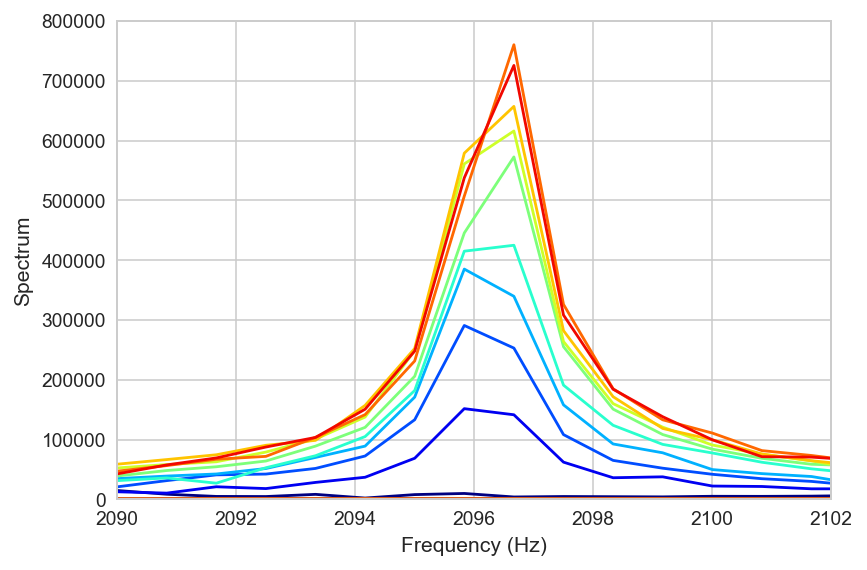

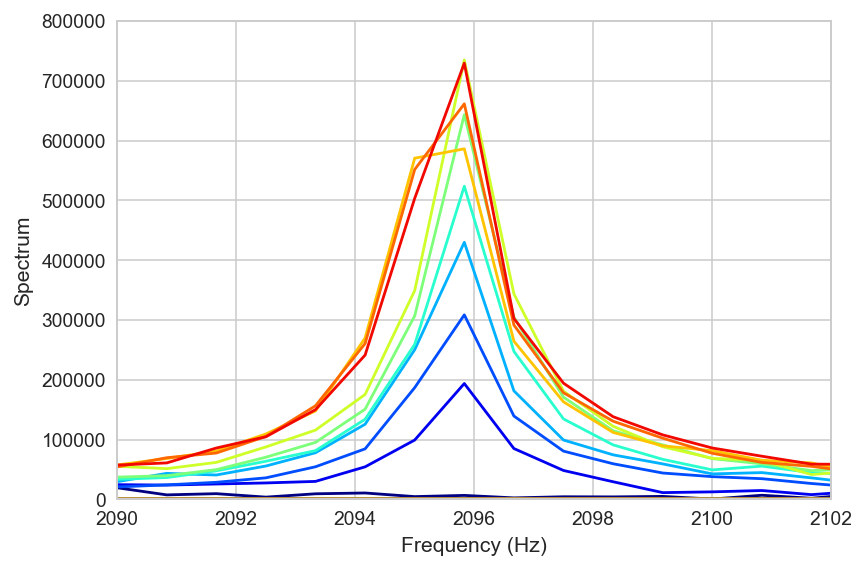

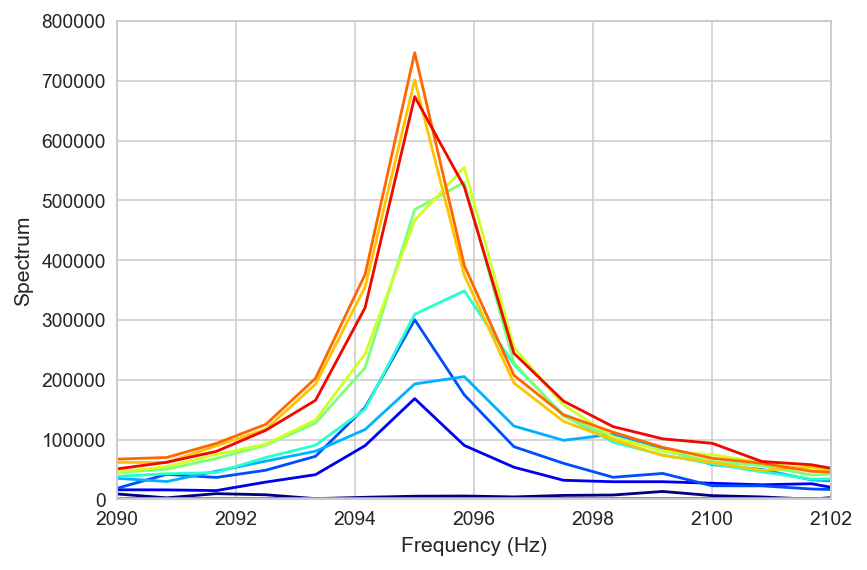

In [32]:
xlims_m = [2090, 2102]
ylims_m = [0, 800000]
plot_ffts(pol_m, data_m, xlims_m, ylims_m)

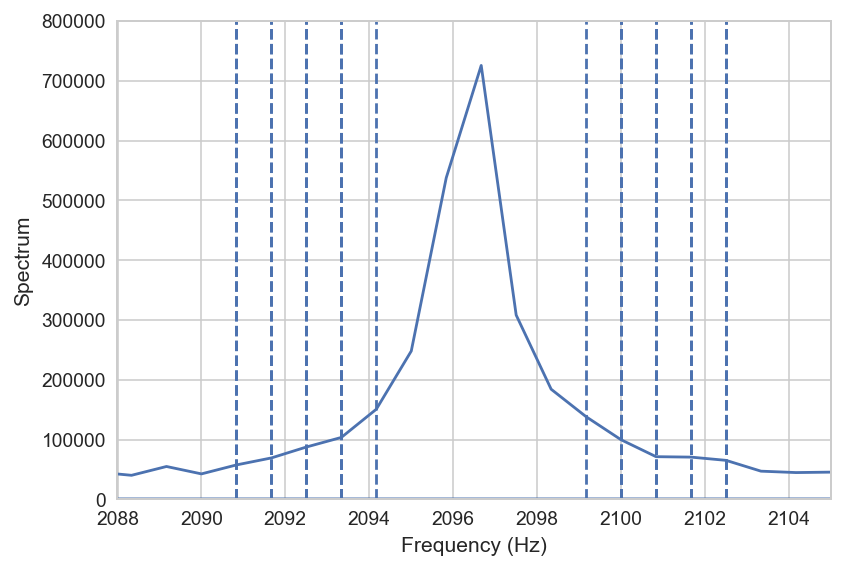

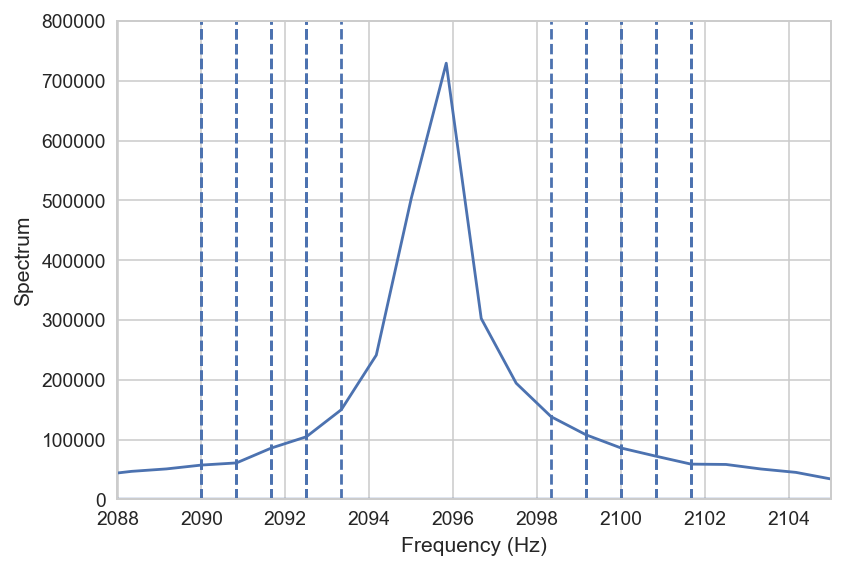

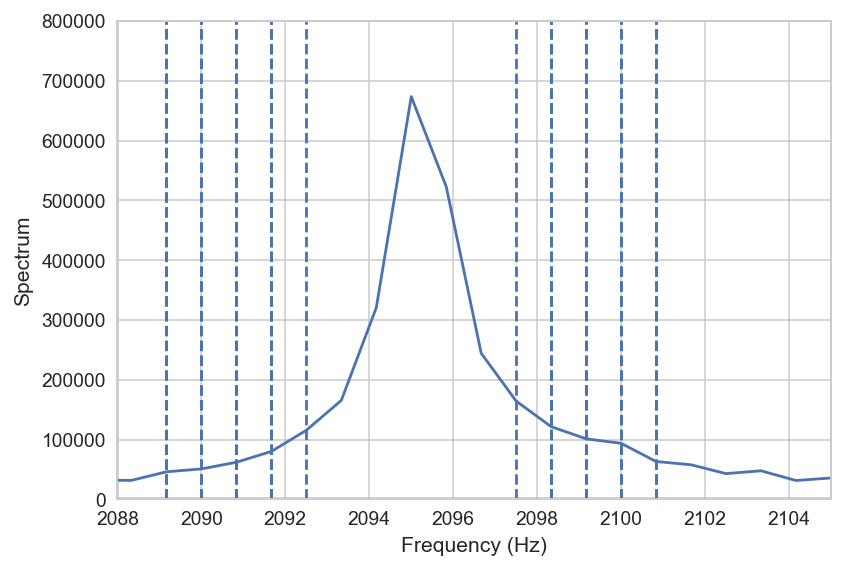

In [33]:
peak_lims_m = [2088, 2105]
peak_widths_m = linspace(6, 13, 10)
ylims_m = [0, 800000]
plot_peak_lims(pol_m, data_m, peak_lims_m, peak_widths_m, ylims_m)

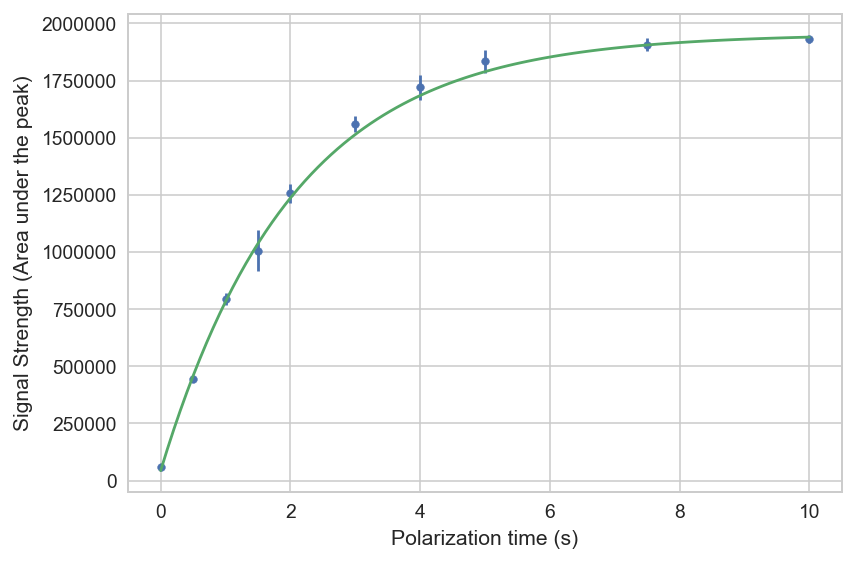

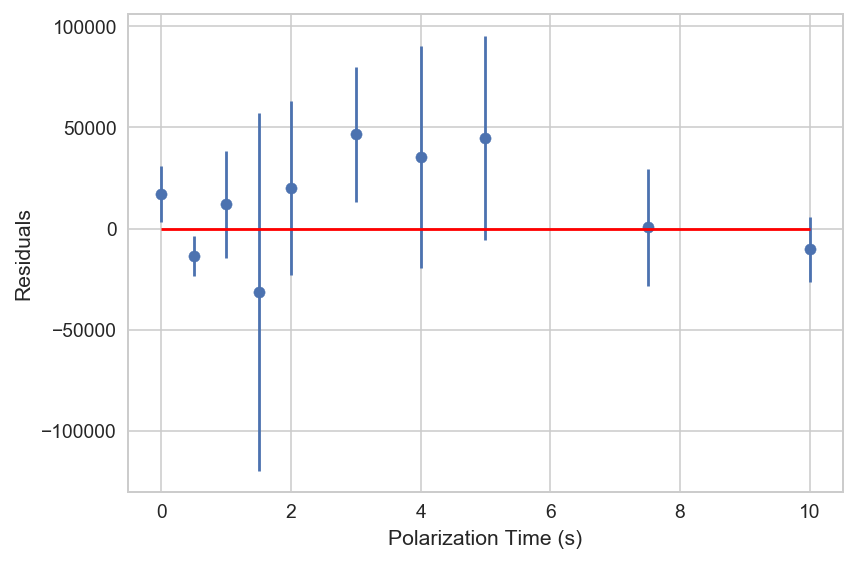

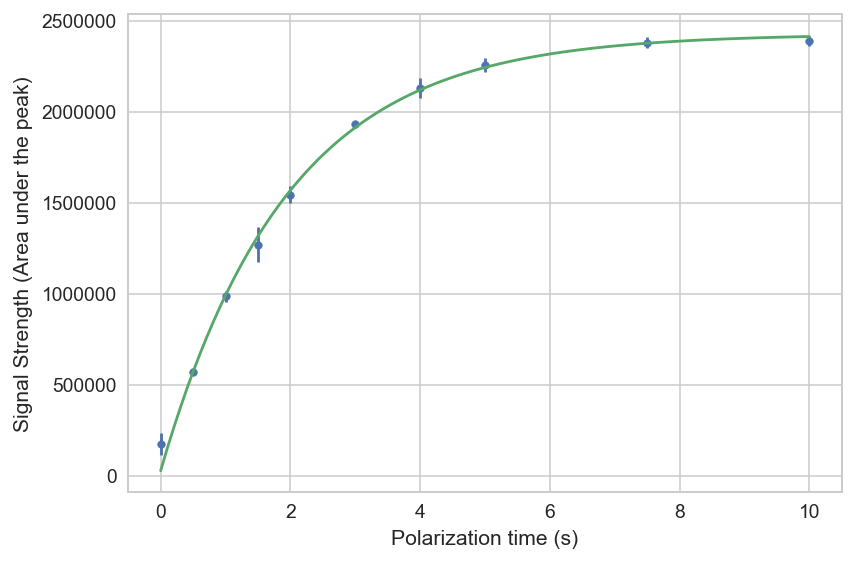

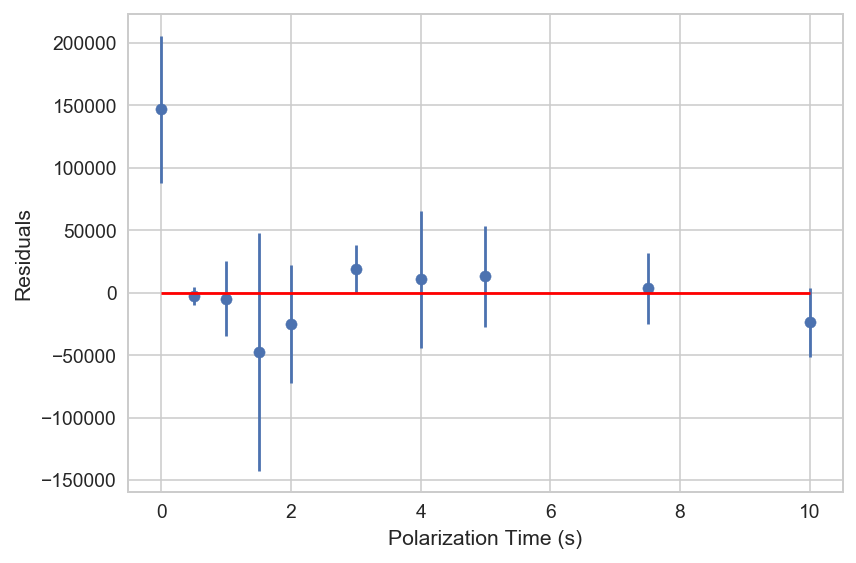

In [34]:
T1_m, uT1_m, popts_m, chi2s_m, pvalues_m, peak_avgs_m, err_peak_avgs_m, T1s_m, uT1s_m = \
    get_T1(data_m, pol_m, peak_lims_m, peak_widths_m, p0=[2, 2000000, 500])

In [35]:
T1_m, uT1_m

(1.9690486040058053, 0.080794732224109142)

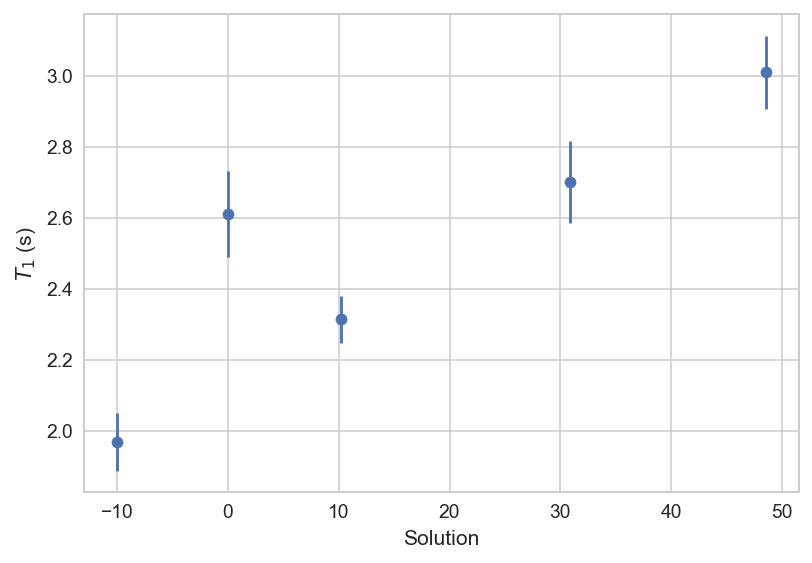

In [36]:
scatter([-10, 0, 10.22, 30.88, 48.55], [T1_m, T1_0, T1_10,T1_30,T1_48])
errorbar([-10, 0, 10.22, 30.88, 48.55], [T1_m, T1_0, T1_10,T1_30,T1_48], yerr=[uT1_m, uT1_0, uT1_10,uT1_30,uT1_48], linestyle='none')
ylabel('$T_1$ (s)')
xlabel('Solution')